<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

In [2]:
# проверка версии
tf.version.VERSION

'2.1.0'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [4]:
# загрузка данных
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)

train_y = train_y.reshape(1,-1)[0]
test_y = test_y.reshape(1,-1)[0]

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000,) int32
(10000,) int32


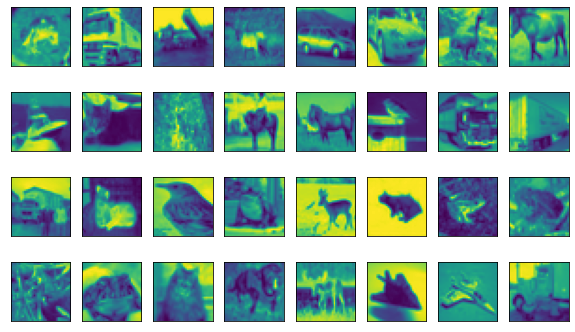

In [5]:
# визуализация
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,0]) #, cmap='gray')
    plt.xticks([]), plt.yticks([])
plt.show()

Базовые классы и функции. TF-style

In [46]:
# архитектура
class Model_2conv(tf.keras.Model):
    
    def __init__(self, kernel_size, conv_1_n, conv_2_n, fc_n, conv_1_f, conv_2_f, fc_f):
        super(Model_2conv, self).__init__()
        self.kernel_size = kernel_size
        self.conv_1_n = conv_1_n
        self.conv_1_f = conv_1_f
        self.conv_2_n = conv_2_n
        self.conv_2_f = conv_2_f
        self.fc_n = fc_n
        self.fc_f = fc_f
                
        self.conv1 = tf.keras.layers.Conv2D(self.conv_1_n, self.kernel_size, activation=self.conv_1_f, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(self.conv_2_n, self.kernel_size, activation=self.conv_2_f, padding='same')
        self.fc1 = tf.keras.layers.Dense(self.fc_n, activation=self.fc_f)
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out
    
# более сложный вариант
class Model_3conv(tf.keras.Model):
    
    def __init__(self, kernel_size, conv_1_n, conv_2_n, conv_3_n, fc_n, 
                 conv_1_f, conv_2_f, conv_3_f, fc_f):
        super(Model_3conv, self).__init__()
        self.kernel_size = kernel_size
        self.conv_1_n = conv_1_n
        self.conv_1_f = conv_1_f
        self.conv_2_n = conv_2_n
        self.conv_2_f = conv_2_f
        self.conv_3_n = conv_3_n
        self.conv_3_f = conv_3_f
        self.fc_n = fc_n
        self.fc_f = fc_f
                
        self.conv1 = tf.keras.layers.Conv2D(self.conv_1_n, self.kernel_size, activation=self.conv_1_f, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(self.conv_2_n, self.kernel_size, activation=self.conv_2_f, padding='same')
        self.conv3 = tf.keras.layers.Conv2D(self.conv_3_n, self.kernel_size, activation=self.conv_3_f, padding='same')
        self.fc1 = tf.keras.layers.Dense(self.fc_n, activation=self.fc_f)
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):

        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.conv3(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [21]:
# функция потерь и метрика
def loss(logits, labels):
    
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=labels))
    
    
    
def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))
    

In [22]:
# генерация пайплайна
def create_pipe(train_x, train_y, n_epochs, batch_size):
    train_pipe = tf.data.Dataset.from_tensor_slices((train_x, train_y))
    train_pipe = train_pipe.shuffle(buffer_size=train_x.shape[0])
    train_pipe = train_pipe.repeat(n_epochs)
    train_pipe = train_pipe.batch(batch_size)
    
    return train_pipe

N_EPOCH = 5
BATCH = 32
train_pipe = create_pipe(train_x, train_y, N_EPOCH, BATCH)

train_pipe

<BatchDataset shapes: ((None, 32, 32, 3), (None,)), types: (tf.float32, tf.int32)>

In [23]:
def run_fit(model, pipe, writer_dir, optimizer, display_step, test_x, test_y):
    writer = tf.summary.create_file_writer(writer_dir)
    
    for i, (images, labels) in enumerate(pipe):
        
        with tf.GradientTape() as tape:
            logits = model(images)
            loss_value = loss(logits, labels)
        
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        if i % display_step == 0:
            test_logits = model(test_x[:256, ...])
            accuracy_value = accuracy(test_logits, test_y[:256, ...])
            
            print("[%4d] Accuracy: %5.2f %%" % (i, accuracy_value.numpy()*100))
            
            with writer.as_default():
                tf.summary.scalar('accuracy', accuracy_value, i)
                tf.summary.scalar('loss', loss_value, i)
    
    test_logits = model(test_x)
    accuracy_value = accuracy(test_logits, test_y).numpy()
    print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))
    
    return model        

In [42]:
# base case
model_1 = Model_2conv(conv_1_n=32, conv_1_f='relu', conv_2_n=64, conv_2_f='relu', fc_f='relu', fc_n=1024,
                   kernel_size=(3,3))

N_EPOCH = 15
BATCH = 32

main_pipe = create_pipe(train_x, train_y, N_EPOCH, BATCH)

optimizer_1 = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_1 = run_fit(model_1, main_pipe, 'logs/adam_2conv', optimizer_1, 1000, test_x, test_y)

[   0] Accuracy:  8.98 %
[1000] Accuracy: 50.00 %
[2000] Accuracy: 50.39 %
[3000] Accuracy: 57.81 %
[4000] Accuracy: 60.55 %
[5000] Accuracy: 62.89 %
[6000] Accuracy: 64.06 %
[7000] Accuracy: 63.28 %
[8000] Accuracy: 67.19 %
[9000] Accuracy: 68.36 %
[10000] Accuracy: 65.23 %
[11000] Accuracy: 67.19 %
[12000] Accuracy: 68.36 %
[13000] Accuracy: 68.75 %
[14000] Accuracy: 69.53 %
[15000] Accuracy: 69.92 %
[16000] Accuracy: 66.02 %
[17000] Accuracy: 66.41 %
[18000] Accuracy: 69.53 %
[19000] Accuracy: 66.80 %
[20000] Accuracy: 66.02 %
[21000] Accuracy: 69.92 %
[22000] Accuracy: 67.58 %
[23000] Accuracy: 69.92 %
Final Accuracy: 71.21 %


In [48]:
# 3-layers case

N_EPOCH = 15
BATCH = 32

main_pipe = create_pipe(train_x, train_y, N_EPOCH, BATCH)

model_2 = Model_3conv(conv_1_n=32, conv_1_f='relu', conv_2_n=64, conv_2_f='relu', conv_3_n=128, conv_3_f='relu',
                      fc_f='relu', fc_n=1024,  kernel_size=(3,3))

optimizer_2 = tf.keras.optimizers.Adam()

model_2 = run_fit(model_2, main_pipe, 'logs/adam_3conv', optimizer_2, 1000, test_x, test_y)

[   0] Accuracy:  9.38 %
[1000] Accuracy: 62.11 %
[2000] Accuracy: 67.58 %
[3000] Accuracy: 70.70 %
[4000] Accuracy: 72.27 %
[5000] Accuracy: 75.78 %
[6000] Accuracy: 74.61 %
[7000] Accuracy: 72.27 %
[8000] Accuracy: 78.12 %
[9000] Accuracy: 76.95 %
[10000] Accuracy: 73.83 %
[11000] Accuracy: 76.56 %
[12000] Accuracy: 74.61 %
[13000] Accuracy: 77.34 %
[14000] Accuracy: 75.78 %
[15000] Accuracy: 75.00 %
[16000] Accuracy: 73.83 %
[17000] Accuracy: 74.22 %
[18000] Accuracy: 76.17 %
[19000] Accuracy: 75.39 %
[20000] Accuracy: 75.00 %
[21000] Accuracy: 74.22 %
[22000] Accuracy: 75.00 %
[23000] Accuracy: 77.34 %
Final Accuracy: 73.97 %


In [60]:
# Predictor call function

def test_item(sample, fitted_model):
    
    logits = fitted_model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,0])
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {}'.format(ans))

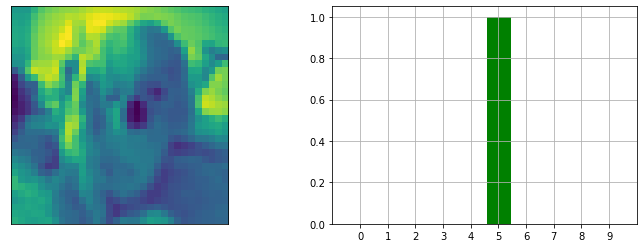

Predicted: 5
True Answer: 5


In [64]:
idx = np.random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample, fitted_model=model_2) # модель с 3 слоями

print('True Answer: {}'.format(test_y[idx]))